See comments_results.ipynb for procedure + results summary

In [141]:
%load_ext autoreload
%autoreload 2

In [155]:
import scipy as sp
import numpy as np
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

import mnist

import aknn

In [131]:
LABELS = np.array(list('0123456789'))
n_samples = 10000
images = mnist.train_images()[:n_samples].astype(np.float32)
samples = (2 * images.reshape(-1, 784) - 255.0) / 255.0
svd = TruncatedSVD(25)
samples = svd.fit_transform(samples)
labels = mnist.train_labels()[:n_samples]

In [133]:
nbrs_list = aknn.calc_nbrs_exact(samples, k=1000)

In [180]:
# add noise

left_rate = 0.0
right_rate = 0.0

left_frac = 0.2
cutoff = 0
while (samples[:, 0] < cutoff).mean() < left_frac:
    cutoff += 0.1

left_side = (samples[:, 0] < cutoff)
right_side = ~left_side
print(left_side.mean())

n_samples = len(samples)

left_mask = left_side & (np.random.sample(n_samples) < left_rate)
right_mask = right_side & (np.random.sample(n_samples) < right_rate)

noise_labels = labels.copy()
noise_labels[left_mask] = np.random.choice(LABELS, left_mask.sum())
noise_labels[right_mask] = np.random.choice(LABELS, right_mask.sum())

0.2067


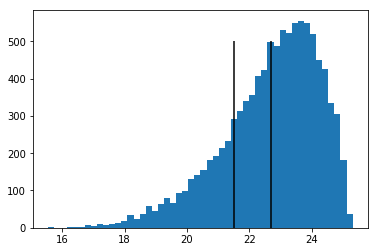

In [181]:
plt.hist(samples[:, 0], bins=50)
plt.vlines([cutoff, samples[:, 0].mean()], 0, 500)
plt.show()

In [182]:
# get aknn predictions
aknn_pred, aknn_ks = aknn.predict_nn_rule(nbrs_list, noise_labels)
aknn_correct = (aknn_pred == labels)

for k in [2, 3, 5, 7, 8, 10, 30, 99]:
    # get knn predictions
    knn_pred = aknn.knn_rule(nbrs_list, noise_labels, k)
    knn_correct = (knn_pred == labels)
    # sample aknn predictions where less than k neighbors used
    aknn_cov_ndces = (aknn_ks <= k)
    aknn_cover = aknn_cov_ndces.mean()
    aknn_cond_acc = aknn_correct[aknn_cov_ndces].mean()
    # print
    print('KNN accuracy (k = %d): \t\t%.4f' % (k, knn_correct.mean()))
    print('AKNN accuracy (k <= %d): \t%.4f \t\t Coverage: %.3f\n' % (k, aknn_cond_acc, aknn_cover))
print('Full AKNN accuracy: %s' % aknn_correct.mean())

KNN accuracy (k = 2): 		0.9511
AKNN accuracy (k <= 2): 	0.9823 		 Coverage: 0.941

KNN accuracy (k = 3): 		0.9578
AKNN accuracy (k <= 3): 	0.9823 		 Coverage: 0.941

KNN accuracy (k = 5): 		0.9571
AKNN accuracy (k <= 5): 	0.9672 		 Coverage: 0.988

KNN accuracy (k = 7): 		0.9532
AKNN accuracy (k <= 7): 	0.9657 		 Coverage: 0.991

KNN accuracy (k = 8): 		0.9544
AKNN accuracy (k <= 8): 	0.9640 		 Coverage: 0.993

KNN accuracy (k = 10): 		0.9524
AKNN accuracy (k <= 10): 	0.9623 		 Coverage: 0.995

KNN accuracy (k = 30): 		0.9385
AKNN accuracy (k <= 30): 	0.9593 		 Coverage: 1.000

KNN accuracy (k = 99): 		0.9153
AKNN accuracy (k <= 99): 	0.9589 		 Coverage: 1.000

Full AKNN accuracy: 0.9589


In [186]:
# get the absolute best k
hi, hi_k = 0, 1
for k in np.arange(2, 30):
    # get knn predictions
    knn_pred = aknn.knn_rule(nbrs_list, noise_labels, k)
    knn_acc = (knn_pred == labels).mean()
    if knn_acc > hi:
        hi, hi_k = knn_acc, k

In [187]:
hi, hi_k

(0.9578, 3)